In [1]:
import keras
import tensorflow as tf
from pathlib import Path
import os
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
import glob
import cv2

from tensorflow.python.client import device_lib

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17814246920174443542
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2236245607
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4725805582509239619
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [4]:
data_dir = Path("./dataset/")
images = sorted([str(i) for i in list(data_dir.glob("*.jpg"))])
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
unique_symbols = sorted(list({char for label in labels for char in label}))

In [5]:
def split_data(images, labels, train_size=0.8, shuffle=True):
    size = len(images)
    indx = np.arange(size)
    if shuffle:
        np.random.shuffle(indx)
    train = int(size * train_size)
    x_train, y_train = images[indx[:train]], labels[indx[:train]]
    x_test, y_test = images[indx[train:]], labels[indx[train:]]
    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = split_data(np.array(images), np.array(labels))

In [7]:
data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
data_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [8]:
batch_size = 16
img_width = 200
img_height = 50
downsample_factor = 4

In [9]:
char_to_num = layers.StringLookup(
    vocabulary=list(unique_symbols), mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

max_length = max([len(label) for label in labels])

In [10]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [11]:
data_train = (
    data_train.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [12]:
data_test = (
    data_test.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

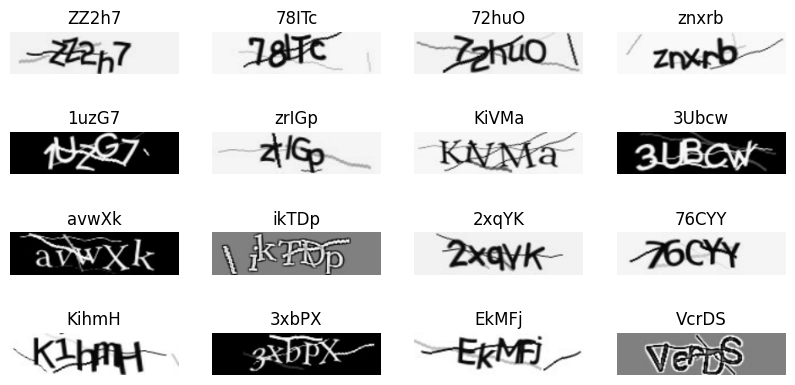

In [13]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in data_train.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [14]:
from sklearn.metrics import accuracy_score

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    
    model.compile(optimizer=keras.optimizers.Adam())
    return model

In [15]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [16]:
epochs = 150
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [17]:
data_train

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [18]:
data_test

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

In [19]:
history = model.fit(
    data_train,
    validation_data=data_test,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/150
1115/1115 [==============================] - 134s 110ms/step - loss: 21.6518 - val_loss: 20.4078
Epoch 2/150
1115/1115 [==============================] - 49s 44ms/step - loss: 20.4167 - val_loss: 20.3491
Epoch 3/150
1115/1115 [==============================] - 49s 44ms/step - loss: 20.3842 - val_loss: 20.3386
Epoch 4/150
1115/1115 [==============================] - 49s 44ms/step - loss: 20.3724 - val_loss: 20.3333
Epoch 5/150
1115/1115 [==============================] - 49s 44ms/step - loss: 20.3651 - val_loss: 20.3244
Epoch 6/150
1115/1115 [==============================] - 53s 48ms/step - loss: 20.2724 - val_loss: 20.1239
Epoch 7/150
1115/1115 [==============================] - 50s 45ms/step - loss: 20.0336 - val_loss: 19.7533
Epoch 8/150
1115/1115 [==============================] - 50s 44ms/step - loss: 19.3478 - val_loss: 18.7273
Epoch 9/150
1115/1115 [==============================] - 50s 45ms/step - loss: 18.3468 - val_loss: 17.6618
Epoch 10/150
1115/1115 [===========

Epoch 78/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.4974 - val_loss: 4.1375
Epoch 79/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.4768 - val_loss: 4.0946
Epoch 80/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.4106 - val_loss: 4.0830
Epoch 81/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.4365 - val_loss: 4.0933
Epoch 82/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.3745 - val_loss: 4.0205
Epoch 83/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.3522 - val_loss: 4.1641
Epoch 84/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.3228 - val_loss: 4.2390
Epoch 85/150
1115/1115 [==============================] - 55s 49ms/step - loss: 3.3083 - val_loss: 4.1962
Epoch 86/150
1115/1115 [==============================] - 54s 49ms/step - loss: 3.2763 - val_loss: 4.2366
Epoch 87/150
1115/1115 [======================

In [20]:
model.save("model_001")

INFO:tensorflow:Assets written to: model_001\assets


INFO:tensorflow:Assets written to: model_001\assets


In [21]:
from keras.models import save_model, load_model

model = load_model("model_001")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

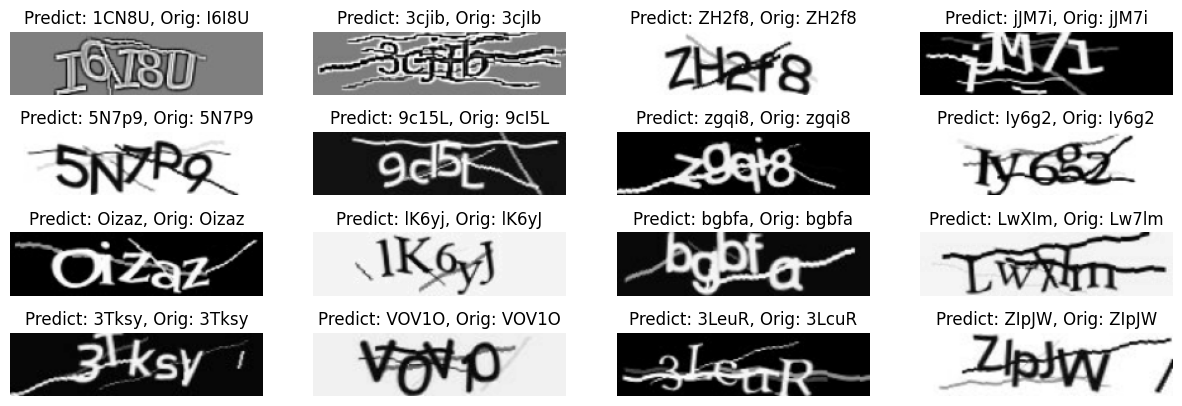

In [22]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in data_test.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Predict: {pred_texts[i]}, Orig: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
orig_texts, pred_texts = [], []

for batch in data_test:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts.append(decode_batch_predictions(preds))

    
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 335ms/step


In [24]:
y = 0
n = 0
res = []
for i in pred_texts:
    for j in i:
        res.append(j)

In [25]:
pre_dict = {u: 0 for u in unique_symbols}
nepre_dict = {u: 0 for u in unique_symbols}
for pred, orig in zip(res, orig_texts):
    for i, j in zip(pred, orig):
        if i == j:
            pre_dict[j] += 1
        else:
            nepre_dict[j] += 1
print("отгаданные", pre_dict)
print("не отгаданные", nepre_dict)
print("acc", {i: pre_dict[i]/(pre_dict[i]+nepre_dict[i]) for i in pre_dict})

отгаданные {'1': 381, '2': 548, '3': 539, '4': 325, '5': 397, '6': 315, '7': 318, '8': 304, '9': 536, 'A': 286, 'B': 268, 'C': 386, 'D': 283, 'E': 428, 'F': 303, 'G': 321, 'H': 303, 'I': 439, 'J': 330, 'K': 330, 'L': 468, 'M': 304, 'N': 336, 'O': 297, 'P': 264, 'Q': 401, 'R': 297, 'S': 226, 'T': 299, 'U': 261, 'V': 393, 'W': 262, 'X': 295, 'Y': 280, 'Z': 325, 'a': 371, 'b': 352, 'c': 261, 'd': 318, 'e': 328, 'f': 377, 'g': 286, 'h': 344, 'i': 278, 'j': 285, 'k': 400, 'l': 279, 'm': 302, 'n': 342, 'p': 369, 'q': 260, 'r': 253, 's': 307, 't': 337, 'u': 286, 'v': 250, 'w': 340, 'x': 285, 'y': 278, 'z': 342}
не отгаданные {'1': 111, '2': 16, '3': 21, '4': 13, '5': 18, '6': 22, '7': 31, '8': 9, '9': 18, 'A': 9, 'B': 14, 'C': 27, 'D': 16, 'E': 39, 'F': 43, 'G': 40, 'H': 19, 'I': 156, 'J': 65, 'K': 21, 'L': 51, 'M': 14, 'N': 21, 'O': 44, 'P': 46, 'Q': 67, 'R': 15, 'S': 23, 'T': 32, 'U': 13, 'V': 16, 'W': 24, 'X': 12, 'Y': 13, 'Z': 37, 'a': 25, 'b': 24, 'c': 59, 'd': 18, 'e': 79, 'f': 72, 'g':

In [26]:
for pred, orig in zip(res, orig_texts):
    for i, j in zip(pred, orig):
        if i == j:
            y+=1 
        else: n+=1

print("Кол отгаданных символов", y)
print("Кол неотгаданных символов", n)
print("Кол символов тестовой выборки", len(list(''.join(list(map(lambda x: ''.join(x), orig_texts))))))
print("acc", y/len(list(''.join(list(map(lambda x: ''.join(x), orig_texts))))))

Кол отгаданных символов 19878
Кол неотгаданных символов 2422
Кол символов тестовой выборки 22300
acc 0.891390134529148


In [27]:
c = 0
res = []
for i in pred_texts:
    for j in i:
        res.append(j)
for pred, orig in zip(res, orig_texts):
    if pred == orig:
        c+=1 
print(c/len(orig_texts))

0.6271300448430494


In [28]:
file = glob.glob("./*.jpg")

In [29]:
images = []

In [30]:
for img in file:
    img = tf.io.read_file(img)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    images.append(img)

1/1 [==============================] - 0s 27ms/step


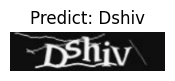

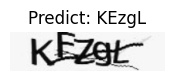

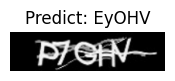

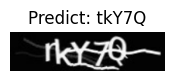

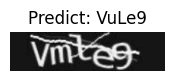

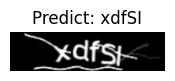

In [31]:
for img in images:
    img = tf.convert_to_tensor(np.expand_dims(img, axis=0), np.float32)
    preds = prediction_model.predict(img)
    pred_texts = decode_batch_predictions(preds)

    _, ax = plt.subplots(1, 1, figsize=(2, 2))
    for i in range(len(pred_texts)):
        img = (img[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Predict: {pred_texts[i]}"
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")
plt.show()